In [ ]:
# single

In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8827160493827161, Loss: 0.47649132763897933
Checkpoint 200, Accuracy: 0.8950617283950617, Loss: 0.4310400927508319
Checkpoint 300, Accuracy: 0.9382716049382716, Loss: 0.3916445838080512
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.3463643391927083
Checkpoint 500, Accuracy: 0.9506172839506173, Loss: 0.31328773498535156


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.85801804 0.04708142 0.09490062]
[1. 0. 0.] <-> [0.8648869  0.03528973 0.09982335]
[0. 0. 1.] <-> [0.3111202  0.00110339 0.6877764 ]
[1. 0. 0.] <-> [0.8350024  0.02257547 0.14242208]
[1. 0. 0.] <-> [0.79810274 0.05994099 0.14195628]
[1. 0. 0.] <-> [0.7452036  0.07859217 0.17620425]
[0. 0. 1.] <-> [0.37219673 0.00697915 0.62082416]
[1. 0. 0.] <-> [0.8759754  0.04472437 0.07930032]
[0. 0. 1.] <-> [0.66077846 0.00182616 0.3373954 ]
[1. 0. 0.] <-> [0.8548103  0.06932715 0.07586253]
[0. 1. 0.] <-> [0.19462356 0.7300812  0.0752953 ]
[1. 0. 0.] <-> [0.86188936 0.0375033  0.10060734]
[1. 0. 0.] <-> [0.8469005  0.05962569 0.09347378]
[1. 0. 0.] <-> [0.7654649  0.00286844 0.23166662]
[1. 0. 0.] <-> [0.85633326 0.04204135 0.10162534]
[1. 0. 0.] <-> [0.8748265  0.06105124 0.06412231]
[1. 0. 0.] <-> [0.853391   0.08750068 0.05910834]
[0. 0. 1.] <-> [0.8780302  0.01894411 0.10302569]
[1. 0. 0.] <-> [0.8711882  0.03402495 0.09478676]
[0. 0. 1.] <-> [2.8869757e-01 3.9917530e-04 7.1090

In [11]:
# Testing Performance

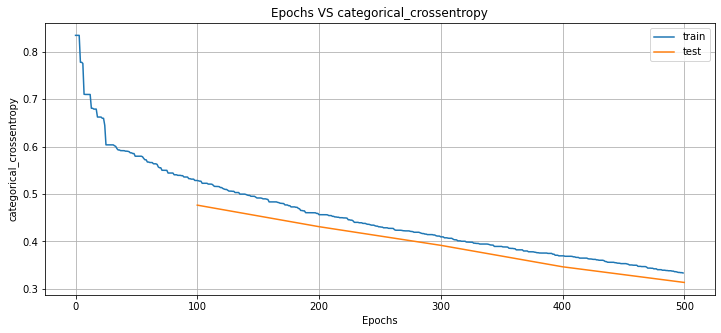

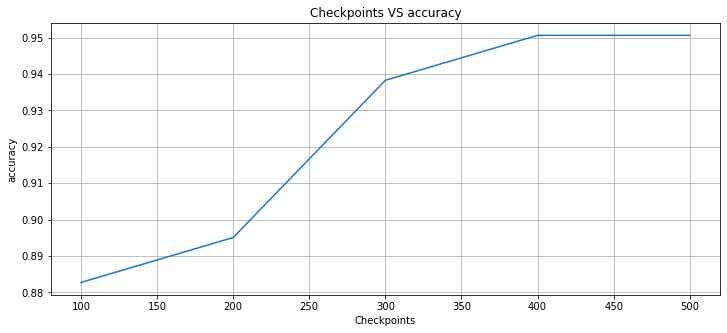

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8827160493827161, 'mean_square_error': 0.26892706578374964, 'categorical_crossentropy': 0.47649132763897933, 'precision': 0.8240740740740741, 'recall': 0.8240740740740741, 'f1': 0.8240740740740741, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 17, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 2, 'tn_hit': 93, 'fn_hit': 13}}, 'checkpoint': 100} 


{'accuracy': 0.8950617283950617, 'mean_square_error': 0.22591758762775604, 'categorical_crossentropy': 0.4310400927508319, 'precision': 0.8425925925925926, 'recall': 0.8425925925925926, 'f1': 0.8425925925925926, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 15, 'tn_hit': 13, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 5}, 2: {'tp_hit': 1, 'fp_hit': 2, 'tn_hit': 93, 'fn_hit': 12}}, 'checkpoint': 200} 


{'accuracy': 0.9382716049382716, 'mean_square_error': 0.1942508468628192, 'categorical_crossentropy': 0.3916445838080512, 'precisi

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.7330189  -2.4991477  -2.231641   -1.6158371   0.98381597]
 bias: 1.609023094177246

Neuron 1: weights:
[ 1.0430095  -1.4779776   0.22387545  0.97165096 -0.28071028]
 bias: -0.4312340021133423

Neuron 2: weights:
[-1.1441323   1.8898981  -1.1659847  -1.2750957  -0.13402633]
 bias: 1.9879236221313477

Neuron 3: weights:
[ 1.1305487  1.0213519  0.0469135 -2.2570093  3.       ]
 bias: -2.6714258193969727

$
Layer 2
Neuron 0: weights:
[2.073644  1.3186045 1.1946291 1.6507183]
 bias: -2.5895426273345947

Neuron 1: weights:
[-2.0283604   0.58562356  2.1128955  -1.0894463 ]
 bias: -1.830722689628601

Neuron 2: weights:
[ 0.05019435  1.7232126  -1.8882592   2.336436  ]
 bias: -0.5051039457321167

$

